In [14]:
import numpy as jnp
import matplotlib.pyplot as plt


## Parameters
x_lb, x_rb = 0, 1
n = 4  # N = 16. Total grid points = 16^3 = 4096.
N_x = 2**n
L = x_rb - x_lb
dx = L/N_x

## 3D Grid
xs, ys, zs = jnp.meshgrid(
    jnp.linspace(x_lb, x_rb, N_x, endpoint=False), 
    jnp.linspace(x_lb, x_rb, N_x, endpoint=False), 
    jnp.linspace(x_lb, x_rb, N_x, endpoint=False),
    indexing='ij'
)

## Diffusion Coefficient Matrix A, 
# div(A grad u) = f
A = jnp.array([
    [3.0, 1.0, 0.5], 
    [1.0, 3.0, 1.0],
    [0.5, 1.0, 3.0]
])


def spectral_eigenvalues(N, L=1.0):
    """Eigenvalues of the 1D derivative operator with periodic condition."""
    # 2j * pi * k
    k = jnp.fft.fftfreq(N, d=L/N) * 2j * jnp.pi  
    return k


In [15]:
# True Solution: u(x,y,z) = sin(2pi x) sin(2pi y) sin(2pi z)
def u_true_func(x, y, z):
    return jnp.sin(2*jnp.pi*x) * jnp.sin(2*jnp.pi*y) * jnp.sin(2*jnp.pi*z)

# Corresponding RHS: f = div(A grad u)
def f_rhs_func(x, y, z):
    # Diagonal parts: -4pi^2 (A00 + A11 + A22) * u
    term_diag = -4 * jnp.pi**2 * (A[0,0] + A[1,1] + A[2,2]) * u_true_func(x, y, z)
    
    # Off-diagonal parts
    term_off = 0
    cx, cy, cz = jnp.cos(2*jnp.pi*x), jnp.cos(2*jnp.pi*y), jnp.cos(2*jnp.pi*z)
    sx, sy, sz = jnp.sin(2*jnp.pi*x), jnp.sin(2*jnp.pi*y), jnp.sin(2*jnp.pi*z)
    
    # u_xy, u_xz, u_yz terms
    u_xy = 4 * jnp.pi**2 * cx * cy * sz
    u_xz = 4 * jnp.pi**2 * cx * sy * cz
    u_yz = 4 * jnp.pi**2 * sx * cy * cz
    
    term_off += 2 * A[0,1] * u_xy
    term_off += 2 * A[0,2] * u_xz
    term_off += 2 * A[1,2] * u_yz
    
    return (term_diag + term_off)


In [16]:
# classical spectral method
def Elliptic_fft_3D(u, N_x=N_x, dx=dx, A=A): 
    u_h = jnp.fft.fftn(u)
    wave = jnp.fft.fftfreq(N_x, d= dx) * 2j* jnp.pi
    k_x, k_y, k_z = jnp.meshgrid(wave, wave, wave, indexing='ij')

    u_xx_h =  k_x* k_x * u_h
    u_yy_h =  k_y *k_y * u_h
    u_zz_h = k_z * k_z * u_h

    u_xy_h = k_x * k_y * u_h
    u_yz_h = k_y * k_z * u_h
    u_zx_h = k_z * k_x * u_h


    u_xx = jnp.fft.ifftn(u_xx_h, s=(N_x, N_x, N_x))
    u_yy = jnp.fft.ifftn(u_yy_h, s=(N_x, N_x, N_x))
    u_zz = jnp.fft.ifftn(u_zz_h, s=(N_x, N_x, N_x))

    u_xy = jnp.fft.ifftn(u_xy_h, s=(N_x, N_x, N_x))
    u_yz = jnp.fft.ifftn(u_yz_h, s=(N_x, N_x, N_x))
    u_zx = jnp.fft.ifftn(u_zx_h, s=(N_x, N_x, N_x))

    term_diag = A[0, 0] * u_xx + A[1, 1] * u_yy + A[2, 2] * u_zz
    term_off = 0
    term_off += 2 * A[0,1] * u_xy
    term_off += 2 * A[0,2] * u_zx
    term_off += 2 * A[1,2] * u_yz


    return term_diag + term_off

In [18]:
### 3D FFT Method

def solver_Elliptic_3D_fft(f, A, N, dx): 
    # Evaluate function on grid
    f_values = f(xs, ys, zs)

    # 1. Forward 3D FFT
    f_h = jnp.fft.fftn(f_values)
    
    # 2. Construct Wavenumbers
    # Get 1D wavenumbers
    wave = spectral_eigenvalues(N, dx*N) 
    
    # Create 3D grids of wavenumbers (kx, ky, kz)
    k_x, k_y, k_z = jnp.meshgrid(wave, wave, wave, indexing='ij')
    
    # Stack for vectorized computation: Shape (3, N, N, N)
    K_vec = jnp.array([k_x, k_y, k_z])
    
    # 3. Compute the denominator: sum(A_ij * ki * kj)
    # Using einsum for efficient calculation of A_ij * k_i * k_j
    denom = jnp.einsum('mn, m..., n... -> ...', A, K_vec, K_vec)
    
    # 4. Inversion (Handle Zero Mode)
    # Avoid division by zero at k=(0,0,0)
    denom[0,0,0] = 1.0
    u_h = f_h / denom
    u_h[0,0,0] = 0.0 # Enforce mean zero condition
    
    # 5. Inverse 3D FFT
    return jnp.real(jnp.fft.ifftn(u_h))


In [ ]:
# Kronecker-based Method

def solver_Elliptic_3D_FG(f, A, N): 
    
    # 1D DFT matrix
    dfmtx = jnp.fft.fft(jnp.eye(N))
    
    # 3D DFT Matrix via Kronecker: F x F x F
    FG = jnp.kron(jnp.kron(dfmtx, dfmtx), dfmtx)
    
    # Inverse 3D DFT Matrix
    dfmtx_inv = jnp.conj(dfmtx).T / N
    GF = jnp.kron(jnp.kron(dfmtx_inv, dfmtx_inv), dfmtx_inv)

    # Diagonal eigenvalue matrix for 1D derivative
    D_diag = spectral_eigenvalues(N)
    D = jnp.diag(D_diag)
    I = jnp.eye(N)
    
    # The spectral operator L is sum of A_ij * (T_i x T_j x T_k)
    # where T is D if the index matches, else I.
    
    # Initialize sparse/dense matrix
    Elliptic_spec = jnp.zeros((N**3, N**3), dtype=complex)
    
    # Helper for 3-way kron
    def kron3(a, b, c):
        return jnp.kron(jnp.kron(a, b), c)

    for i in range(3):
        for j in range(3):
            val = A[i, j]
            # Identify components [x_op, y_op, z_op]
            # Default to Identity
            mats = [I, I, I] 
            
            # Update for derivative i
            if i == 0: mats[0] = D
            elif i == 1: mats[1] = D
            elif i == 2: mats[2] = D
            
            # Multiply for derivative j (order doesn't matter for diagonal D matrices)
            if j == 0: mats[0] = mats[0] @ D
            elif j == 1: mats[1] = mats[1] @ D
            elif j == 2: mats[2] = mats[2] @ D
            
            # Add to total operator
            Elliptic_spec += val * kron3(mats[0], mats[1], mats[2])

    f_flatten = f(xs, ys, zs).flatten()
    f_h = FG @ f_flatten

    # 2. Inversion (Solve linear system)
    Elliptic_spec[0, 0] = 1.0
    inverse_Elliptic = jnp.linalg.inv(Elliptic_spec)
    inverse_Elliptic[0, 0] = 0.0

    # 3. Inverse Transform
    u_flatten = GF @ (inverse_Elliptic @ f_h)

    return u_flatten.reshape(N, N, N).real



Rel Error FFT Solver: 3.61192e-16
Rel Error Kron Solver: 7.67605e-16


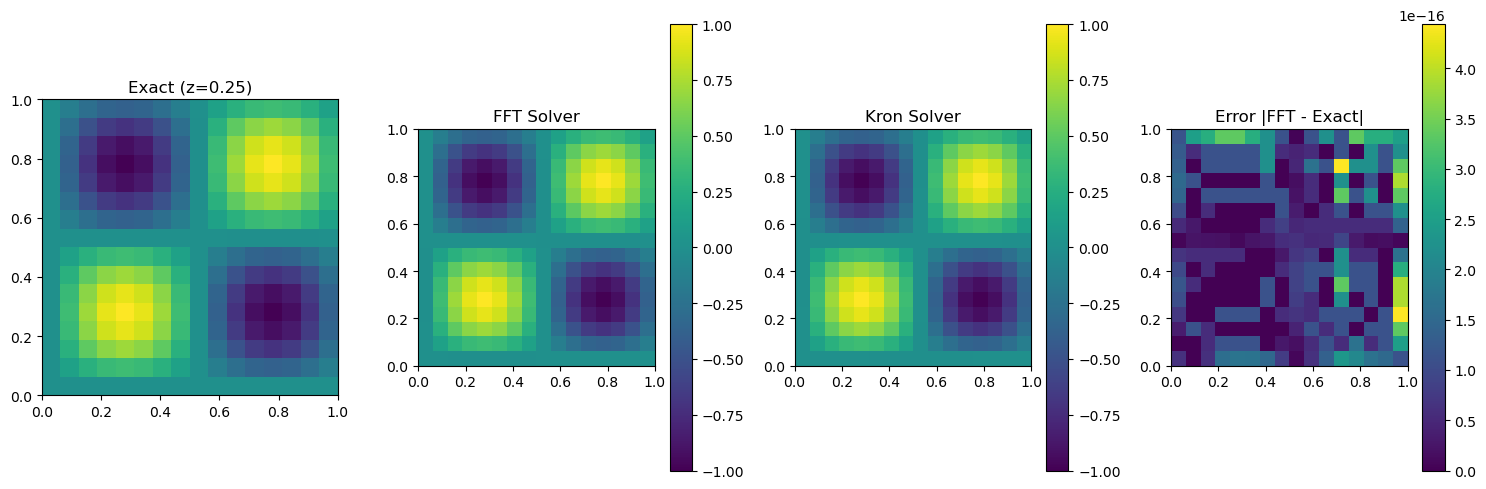

In [ ]:
u_exact = u_true_func(xs, ys, zs)

# Run Solvers
print("Running FFT Solver...")
u_fft = solver_Elliptic_3D_fft(f_rhs_func, A=A, N=N_x, dx=dx)

print("Running Kronecker Solver...")
u_kron = solver_Elliptic_3D_FG(f_rhs_func, A, N_x)

# Error Analysis
err_fft = jnp.linalg.norm(u_fft - u_exact) / jnp.linalg.norm(u_exact)
err_kron = jnp.linalg.norm(u_kron - u_exact) / jnp.linalg.norm(u_exact)

print(f"Rel Error FFT Solver: {err_fft:.5e}")
print(f"Rel Error Kron Solver: {err_kron:.5e}")

# Plotting
z_idx = N_x // 4
z_val = zs[0,0,z_idx]

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(u_exact[:, :, z_idx], origin='lower', extent=[x_lb, x_rb, x_lb, x_rb], vmin=-1, vmax=1)
plt.title(f"Exact (z={z_val:.2f})")

plt.subplot(1, 4, 2)
plt.imshow(u_fft[:, :, z_idx], origin='lower', extent=[x_lb, x_rb, x_lb, x_rb], vmin=-1, vmax =1)
plt.title("FFT Solver")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(u_kron[:, :, z_idx], origin='lower', extent=[x_lb, x_rb, x_lb, x_rb], vmin=-1, vmax=1)
plt.title("Kron Solver")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(jnp.abs(u_fft[:, :, z_idx] - u_exact[:, :, z_idx]), origin='lower', extent=[x_lb, x_rb, x_lb, x_rb])
plt.title("Error |FFT - Exact|")
plt.colorbar()

plt.tight_layout()
plt.show()